In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

# Define paths
train_path = 'C:/Users/preet/Downloads/Final_Project/Disease-Detection-Based-on-Nail-Color-Analysis-Using-Image-Processing-and-Machine-Learning/backend/archive/data/train'
validation_path = 'C:/Users/preet/Downloads/Final_Project/Disease-Detection-Based-on-Nail-Color-Analysis-Using-Image-Processing-and-Machine-Learning/backend/archive/data/validation'

In [6]:
def create_image_dataset(directory, img_size=(128, 128), batch_size=32):
    """Create a TensorFlow dataset from a directory of images."""
    datagen = ImageDataGenerator(rescale=1.0/255) 
    
    dataset = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  
        shuffle=True
    )
    
    return dataset

# Create datasets
train_dataset = create_image_dataset(train_path)
val_dataset = create_image_dataset(validation_path)


Found 3027 images belonging to 6 classes.
Found 82 images belonging to 6 classes.


In [7]:
# Create a CNN feature extractor
def create_feature_extractor(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5)
    ])
    return model

feature_extractor = create_feature_extractor()

c:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
#Extract features from images
def extract_features(dataset, feature_extractor):
    features = []
    labels = []
    
    # Reset generator to ensure we start from the beginning
    dataset.reset()
    
    # Calculate number of batches
    num_batches = len(dataset)
    
    for _ in range(num_batches):
        x, y = dataset.__next__()  
        features_batch = feature_extractor.predict(x)
        features.append(features_batch)
        labels.append(y)
        
    return np.vstack(features), np.vstack(labels)

# Extract features for training and validation
X_train, y_train = extract_features(train_dataset, feature_extractor)
X_val, y_val = extract_features(val_dataset, feature_extractor)

# Convert one-hot encoded labels back to class indices for XGBoost
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━

In [10]:
#Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softprob',
    num_class=len(train_dataset.class_indices),
    n_jobs=-1
)



Epoch 1/10
[0]	validation_0-mlogloss:1.71235
[1]	validation_0-mlogloss:1.65261
[2]	validation_0-mlogloss:1.60301
[3]	validation_0-mlogloss:1.56378
[4]	validation_0-mlogloss:1.52643
[5]	validation_0-mlogloss:1.49153
[6]	validation_0-mlogloss:1.46761
[7]	validation_0-mlogloss:1.44230
[8]	validation_0-mlogloss:1.42977
[9]	validation_0-mlogloss:1.41130
[10]	validation_0-mlogloss:1.39851
[11]	validation_0-mlogloss:1.38515
[12]	validation_0-mlogloss:1.36803
[13]	validation_0-mlogloss:1.35551
[14]	validation_0-mlogloss:1.34882
[15]	validation_0-mlogloss:1.33629
[16]	validation_0-mlogloss:1.32920
[17]	validation_0-mlogloss:1.32452
[18]	validation_0-mlogloss:1.32402
[19]	validation_0-mlogloss:1.32163
[20]	validation_0-mlogloss:1.31701
[21]	validation_0-mlogloss:1.31398
[22]	validation_0-mlogloss:1.31007
[23]	validation_0-mlogloss:1.31110
[24]	validation_0-mlogloss:1.30920
[25]	validation_0-mlogloss:1.30640
[26]	validation_0-mlogloss:1.30261
[27]	validation_0-mlogloss:1.30451
[28]	validation_0-

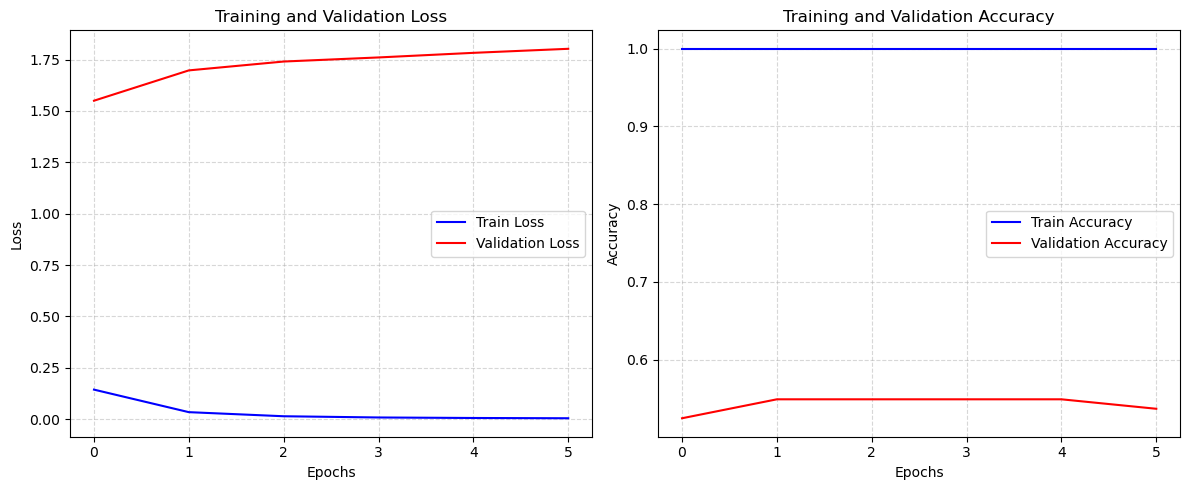


Final Evaluation:
Number of classes: 6
Validation Loss: 1.8023
Validation Accuracy: 0.5366


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

# After creating your datasets and feature extractor, add this:
num_classes = len(train_dataset.class_indices)  # Get number of classes from the dataset


# Initialize history dictionary
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Training parameters
epochs = 10
early_stopping_rounds = 5
best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Fit the model
    xgb_model.fit(
        X_train, y_train_labels,
        eval_set=[(X_val, y_val_labels)],
        verbose=True,
        xgb_model=None if epoch == 0 else xgb_model
    )
    
    # Calculate metrics
    train_probs = xgb_model.predict_proba(X_train)
    val_probs = xgb_model.predict_proba(X_val)
    
    train_loss = log_loss(y_train_labels, train_probs)
    val_loss = log_loss(y_val_labels, val_probs)
    
    train_pred = np.argmax(train_probs, axis=1)
    val_pred = np.argmax(val_probs, axis=1)
    
    train_acc = accuracy_score(y_train_labels, train_pred)
    val_acc = accuracy_score(y_val_labels, val_pred)
    
    # Store metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
    
    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_rounds:
            print(f"\nEarly stopping at epoch {epoch + 1}")
            break

# Plotting the history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'b-', label='Train Loss')
plt.plot(history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'b-', label='Train Accuracy')
plt.plot(history['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Final evaluation
final_val_pred = xgb_model.predict(X_val)
final_val_acc = accuracy_score(y_val_labels, final_val_pred)
final_val_probs = xgb_model.predict_proba(X_val)
final_val_loss = log_loss(y_val_labels, final_val_probs)

print("\nFinal Evaluation:")
print(f"Number of classes: {num_classes}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")